# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [40]:
# Imports here
import json
import os
import logging

import matplotlib.pyplot as plt
import numpy as np
import torch

from collections import OrderedDict

from matplotlib.ticker import FormatStrFormatter
from PIL import Image
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms

logging.getLogger().setLevel(logging.INFO)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [41]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [42]:
# TODO: Define your transforms for the training, validation, and testing sets
def get_datasets_and_loaders(data_dir):
    """ Returns a dictionary containing trining, test and validation datasets and data loaders
    """
    train_dir = os.path.join(data_dir, 'train')
    valid_dir = os.path.join(data_dir, 'valid')
    test_dir = os.path.join(data_dir, 'test')

    data_transforms = {
        'train': transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])]),
        'test_validation': transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406],
                                                                    [0.229, 0.224, 0.225])])
    }

    image_datasets = {
        'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
        'test': datasets.ImageFolder(test_dir, transform=data_transforms['test_validation']),
        'validation': datasets.ImageFolder(valid_dir, transform=data_transforms['test_validation'])
    }

    dataloaders = {
        'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
        'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=True),
        'validation': torch.utils.data.DataLoader(image_datasets['validation'], batch_size=32, shuffle=True)
    }

    return image_datasets, dataloaders

image_datasets, dataloaders = get_datasets_and_loaders('flowers')

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [43]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [44]:
# TODO: Build and train your network

def build_model(architecture, hidden_units=120, dropout=0.5, lr=0.001):
    """
    Builds a deep CNN to classify images of flowers
    :param architecture: Architecture to use for the CNN
    :param hidden_units: Number of hidden units in the first FC layer
    :param dropout: Probability of dropout
    :param lr: Learning rate
    :return: mode, criterion, optimizer
    """
    arch = getattr(models, architecture)
    model = arch(pretrained=True)

    if architecture.startswith('dense'):
        input_size = model.classifier.in_features
    else:
        input_size = model.classifier[0].in_features

    logging.info('Building model with architecture: {}'.format(architecture))

    # Save the model architecture for future loading
    model.architecture = architecture
    model.learning_rate = lr
    model.dropout = dropout

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
        ('dropout', nn.Dropout(dropout)),
        ('fc1', nn.Linear(input_size, hidden_units)),
        ('relu1', nn.ReLU()),
        ('fc2', nn.Linear(hidden_units, 90)),
        ('relu2', nn.ReLU()),
        ('fc3', nn.Linear(90, 80)),
        ('relu3', nn.ReLU()),
        ('fc4', nn.Linear(80, 102)),
        ('output', nn.LogSoftmax(dim=1))]))

    model.classifier = classifier

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

    return model, criterion, optimizer

In [45]:
model, criterion, optimizer = build_model(architecture='densenet121')

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
INFO:root:Building model with architecture: densenet121


In [46]:
def get_device(gpu=True):
    """ Returns the device to run the model training on
    :param gpu: If available, train on GPU
    """
    return torch.device("cuda:0" if torch.cuda.is_available() and gpu else "cpu")

In [47]:
def train(model, criterion, optimizer, epochs=15, print_every=40, gpu=True, save=True, save_dir='.'):
    """
    Trains a deep CNN to classify images of flowers

    :param model: Model to train
    :param criterion: Loss funtion
    :param optimizer: Loss function optimizer
    :param epochs: Number of epochs to run the training
    :param print_every: Print progress every print_every steps
    :param gpu: Train on a GPU (if available)
    :param save: Save the trained model on disk or not
    :param save_dir: Directory where to save the checkpoint file
    :return:
    """
    device = get_device(gpu)
    image_datasets, dataloaders = get_datasets_and_loaders('flowers')

    steps = 0
    model.to(device)
    
    # Save model hyperparameters
    model.epochs = epochs

    for e in range(epochs):
        running_loss = 0
        for ii, (inputs, labels) in enumerate(dataloaders['train']):
            steps += 1
            model.train()

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                model.eval()
                val_loss = 0
                accuracy = 0

                for ii, (inputs_val, labels_val) in enumerate(dataloaders['validation']):
                    optimizer.zero_grad()

                    inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                    model.to(device)
                    with torch.no_grad():
                        outputs = model.forward(inputs_val)
                        val_loss = criterion(outputs, labels_val)
                        ps = torch.exp(outputs).data
                        equality = (labels_val.data == ps.max(1)[1])
                        accuracy += equality.type_as(torch.FloatTensor()).mean()

                val_loss = val_loss / len(dataloaders['validation'])
                accuracy = accuracy / len(dataloaders['validation'])

                print("Epoch: {}/{}... ".format(e + 1, epochs),
                      "Loss: {:.4f}".format(running_loss / print_every),
                      "Validation Loss {:.4f}".format(val_loss),
                      "Accuracy: {:.4f}".format(accuracy))

                running_loss = 0

In [48]:
train(model, criterion, optimizer)

Epoch: 1/15...  Loss: 4.5228 Validation Loss 0.1660 Accuracy: 0.1122
Epoch: 1/15...  Loss: 4.2105 Validation Loss 0.1453 Accuracy: 0.1434
Epoch: 2/15...  Loss: 1.4762 Validation Loss 0.1107 Accuracy: 0.2333
Epoch: 2/15...  Loss: 3.1710 Validation Loss 0.0792 Accuracy: 0.4192
Epoch: 2/15...  Loss: 2.8974 Validation Loss 0.0902 Accuracy: 0.4627
Epoch: 3/15...  Loss: 2.2721 Validation Loss 0.0780 Accuracy: 0.5063
Epoch: 3/15...  Loss: 2.4811 Validation Loss 0.0622 Accuracy: 0.5339
Epoch: 4/15...  Loss: 0.6262 Validation Loss 0.0514 Accuracy: 0.5398
Epoch: 4/15...  Loss: 2.2490 Validation Loss 0.0399 Accuracy: 0.5785
Epoch: 4/15...  Loss: 2.1688 Validation Loss 0.0579 Accuracy: 0.6458
Epoch: 5/15...  Loss: 1.3804 Validation Loss 0.0398 Accuracy: 0.6410
Epoch: 5/15...  Loss: 2.0636 Validation Loss 0.0558 Accuracy: 0.6620
Epoch: 6/15...  Loss: 0.2470 Validation Loss 0.0449 Accuracy: 0.6934
Epoch: 6/15...  Loss: 1.9526 Validation Loss 0.0417 Accuracy: 0.6768
Epoch: 6/15...  Loss: 1.8843 Valid

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [49]:
# TODO: Do validation on the test set

def check_accuracy(model, test_data):
    """
    Checks accuracy of a model
    """
    correct = 0
    total = 0
    device = get_device()
    with torch.no_grad():
        model.eval()
        model.to(get_device())
        for data in test_data:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*correct / total

In [50]:
accuracy = check_accuracy(model, dataloaders['test'])
logging.info('Accuracy of the network on the test images: %d %%' % accuracy)

INFO:root:Accuracy of the network on the test images: 85 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [51]:
# TODO: Save the checkpoint 
def save_model(model, class_to_idx, dest='.'):
    """
    Saves a model in disk
    :param model: PyTorch model
    :param class_to_idx: Map of indexes to classes
    :param dest: where to save the model
    """
    dest = os.path.join(dest, 'checkpoint.pth')
    model.class_to_idx = class_to_idx
    torch.save({'state_dict': model.state_dict(),
                'class_to_idx': model.class_to_idx,
                'architecture': model.architecture,
                'learning_rate': model.learning_rate,
                'dropout': model.dropout,
                'epochs': model.epochs},
                dest)

In [52]:
save_model(model, image_datasets['train'].class_to_idx)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [53]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(path):
    """
    Loads a model from disc
    :param path: Path to the model
    :return:
    """
    checkpoint = torch.load(path)
    m, c, o = build_model(checkpoint['architecture'])
    m.class_to_idx = checkpoint['class_to_idx']
    m.load_state_dict(checkpoint['state_dict'])
    m.architecture = checkpoint['architecture']
    m.learning_rate = checkpoint['learning_rate']
    m.dropout = checkpoint['dropout']
    m.epochs = checkpoint['epochs']

    return m, c, o

In [54]:
m, _, _ = load_model('checkpoint.pth')

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
INFO:root:Building model with architecture: densenet121


In [55]:
# Make sure the model was loaded correctly by checking accuracy on test data with the new loaded model
accuracy = check_accuracy(m, dataloaders['test'])
logging.info('Accuracy of the network on the test images: %d %%' % accuracy)

INFO:root:Accuracy of the network on the test images: 85 %


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [56]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img_pil = Image.open(image)

    # Resize
    size = 256
    width, height = img_pil.size
    shortest_side = min(width, height)
    img_pil = img_pil.resize((int((width/shortest_side)*size), int((height/shortest_side)*size)))

    # Center crop to 224 x 224
    left = (256 - 224)/2
    top = (256 - 224)/2
    right = (256 + 224)/2
    bottom = (256 + 224)/2
    img_pil = img_pil.crop((left, top, right, bottom))

    # Convert image to a numpy array
    img = (np.array(img_pil))/255

    # Normalize the pixel values
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean)/std
    
    img = img.transpose((2, 0, 1))

    return img

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [57]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

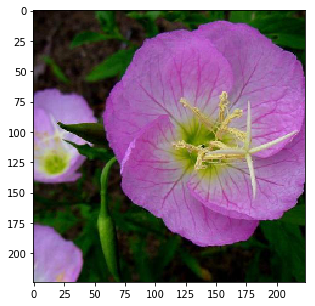

In [58]:
# Test process_image with an image from the test dataset
imshow(process_image("flowers/test/1/image_06764.jpg"))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [59]:
def predict(image_path, model, topk=1, gpu=True, cat_to_name=None):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.to(get_device(gpu))
    img = process_image(image_path)
    img_torch = torch.from_numpy(img)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda())
        
    probabilities = F.softmax(output.data,dim=1).topk(topk) 
    index_to_class = {val: key for key, val in model.class_to_idx.items()}
    
    probs = np.array(probabilities[0][0])
    classes = [cat_to_name[index_to_class[i]] for i in np.array(probabilities[1][0])] if cat_to_name is not None \
                    else [index_to_class[i] for i in np.array(probabilities[1][0])]
    
    # Log the prediction results for the user to see them
    logging.info('\n'.join(['Class: {} with probability {}'.format(c, p) for c, p in zip(classes, probs)]))
    
    return probs, classes

In [60]:
probs, classes = predict(os.path.join(test_dir, '1/image_06743.jpg'), m, cat_to_name=cat_to_name, topk=5)

INFO:root:Class: pink primrose with probability 0.9382275342941284
Class: hibiscus with probability 0.024763742461800575
Class: petunia with probability 0.01700121909379959
Class: tree mallow with probability 0.007654753513634205
Class: hippeastrum with probability 0.002552261808887124


In [61]:
print(probs)
print(classes)

[ 0.93822753  0.02476374  0.01700122  0.00765475  0.00255226]
['pink primrose', 'hibiscus', 'petunia', 'tree mallow', 'hippeastrum']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

INFO:root:Class: pink primrose with probability 0.9382275342941284
Class: hibiscus with probability 0.024763742461800575
Class: petunia with probability 0.01700121909379959
Class: tree mallow with probability 0.007654753513634205
Class: hippeastrum with probability 0.002552261808887124


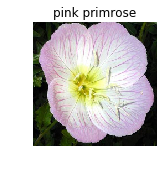

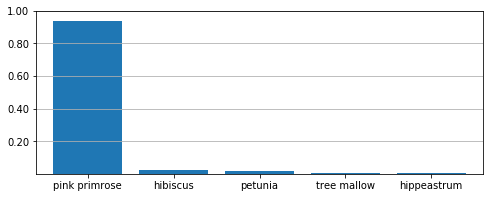

In [62]:
# TODO: Display an image along with the top 5 classes

plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(211)

index = 1
path = test_dir + '/1/image_06743.jpg'

probs, classes = predict(path, m, cat_to_name=cat_to_name, topk=5)
image = process_image(path)


axs = imshow(image, ax = plt)
axs.axis('off')
axs.title(cat_to_name[str(index)])
axs.show()


N=float(len(classes))
fig,ax = plt.subplots(figsize=(8,3))
width = 0.8
tickLocations = np.arange(N)
ax.bar(tickLocations, probs, width, linewidth=4.0, align = 'center')
ax.set_xticks(ticks = tickLocations)
ax.set_xticklabels(classes)
ax.set_xlim(min(tickLocations)-0.6,max(tickLocations)+0.6)
ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
ax.set_ylim((0,1))
ax.yaxis.grid(True)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()